In [1]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.figdir = '../figures/'
sc.settings.set_figure_params(dpi=70)
sns.set_style('white')

%load_ext autoreload
%autoreload 2 

scanpy==1.7.1 anndata==0.7.4 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 louvain==0.7.0 leidenalg==0.8.3


# Dataloading

In [2]:
data_dir = '/storage/groups/bcf/projects/SingleCell/10x/projects/theis/nested_stress_MRGRkd/rev6/scanpy_AnnData/'

In [3]:
stress_ids = [
    'GR_Ctrl_393', 
    'GR_Ctrl_493', 
    'GR_Ctrl_499', 
    'GR_Dlx_495', 
    'GR_Dlx_497', 
    'GR_Dlx_505',
    'GR_Nex_395', 
    'GR_Nex_399', 
    'GR_Nex_405', 
    'MR_Ctrl_147', 
    'MR_Ctrl_149', 
    'MR_Ctrl_163',
    'MR_Dlx_143', 
    'MR_Dlx_145', 
    'MR_Dlx_153', 
    'MR_Nex_165', 
    'MR_Nex_173', 
    'MR_Nex_179'
]

ctrl_ids = [
    'GR_Ctrl_401', 
    'GR_Ctrl_503', 
    'GR_Ctrl_507', 
    'GR_Dlx_513', 
    'GR_Dlx_515', 
    'GR_Dlx_521',
    'GR_Nex_407', 
    'GR_Nex_409', 
    'GR_Nex_411', 
    'MR_Ctrl_151', 
    'MR_Ctrl_155', 
    'MR_Ctrl_171',
    'MR_Dlx_159',
    'MR_Dlx_163',
    'MR_Dlx_165', 
    'MR_Nex_181',
    'MR_Nex_187'
]

adatas = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        data_string = os.path.join(subdir, file).split('/')[-2:]
        if ('filtered' in data_string[-1] and 'GR_Dlx' in data_string[0]):
            exp_id = data_string[0].split('_')
            adata_tmp = sc.read_h5ad(data_dir + data_string[0] + '/filtered_feature_bc_matrix.h5ad')
            print('Reading file ' + data_string[0] + '/filtered_feature_bc_matrix.h5ad')
            adata_tmp.obs['knockout'] = exp_id[0]
            adata_tmp.obs['line'] = exp_id[1]
            adata_tmp.obs['mouse'] = '_'.join((exp_id[1], exp_id[2]))
            if data_string[0] in stress_ids: adata_tmp.obs['condition'] = 'Stress'
            else: adata_tmp.obs['condition'] = 'No Stress'
            adata_tmp.obs['sample'] = data_string[0]
            adatas.append(adata_tmp)
            
adata = adatas[0].concatenate(adatas[1:])

Reading file GR_Dlx_495/filtered_feature_bc_matrix.h5ad
Reading file GR_Dlx_515/filtered_feature_bc_matrix.h5ad
Reading file GR_Dlx_505/filtered_feature_bc_matrix.h5ad
Reading file GR_Dlx_513/filtered_feature_bc_matrix.h5ad
Reading file GR_Dlx_521/filtered_feature_bc_matrix.h5ad
Reading file GR_Dlx_497/filtered_feature_bc_matrix.h5ad


In [4]:
print(adata.obs['knockout'].value_counts())
print('')
print(adata.obs['line'].value_counts())
print('')
print(adata.obs['condition'].value_counts())

GR    27502
Name: knockout, dtype: int64

Dlx    27502
Name: line, dtype: int64

Stress       13969
No Stress    13533
Name: condition, dtype: int64


In [5]:
adata.obs['comb'] = adata.obs[['knockout', 'line', 'condition']].apply(lambda x: ' '.join(x), axis=1)

# QC by sample (GR Dlx)

In [6]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
ribo_gene_mask = [(gene.startswith('Rps') or gene.startswith('Rpl')) for gene in adata.var_names]
hbb_gene_mask = [gene.startswith('Hbb') for gene in adata.var_names]

adata.obs['hbb_frac'] = (
    np.asarray(
        adata
        .X[:, np.flatnonzero(hbb_gene_mask)]
        .sum(1)
    )
    .flatten()
    / adata.obs['n_counts']
)

adata.obs['ribo_frac'] = (
    np.asarray(
        adata
        .X[:, np.flatnonzero(ribo_gene_mask)]
        .sum(1)
    )
    .flatten()
    / adata.obs['n_counts']
)

adata.obs['mt_frac'] = (
    np.asarray(
        adata
        .X[:, np.flatnonzero(mt_gene_mask)]
        .sum(1)
    )
    .flatten()
    / adata.obs['n_counts']
)

In [7]:
print(adata.obs['mouse'].value_counts())

Dlx_505    4930
Dlx_521    4868
Dlx_497    4672
Dlx_513    4555
Dlx_495    4367
Dlx_515    4110
Name: mouse, dtype: int64


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'knockout' as categorical
... storing 'line' as categorical
... storing 'mouse' as categorical
... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'comb' as categorical


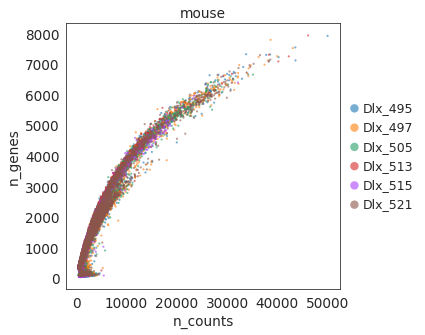

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


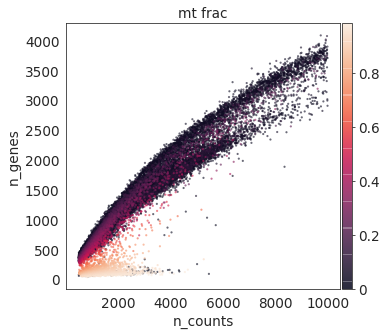

In [8]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(
    adata, 
    'n_counts', 
    'n_genes', 
    size=20, 
    color='mouse', 
    alpha=0.6
)

sc.pl.scatter(
    adata[adata.obs['n_counts']<10000], 
    'n_counts', 
    'n_genes', 
    color='mt_frac', 
    size=20, 
    alpha=0.6
)

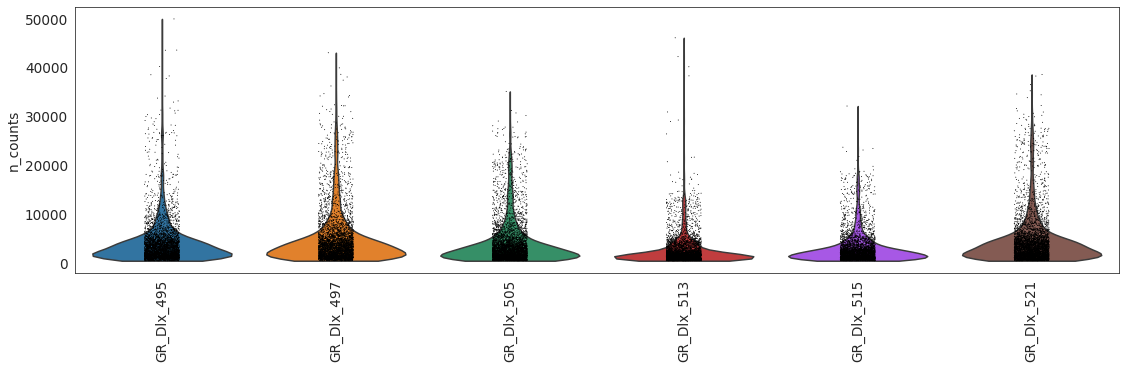

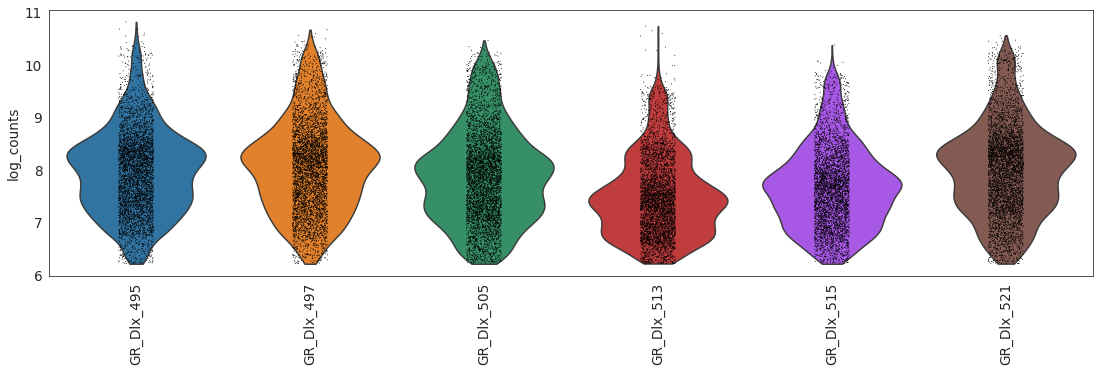

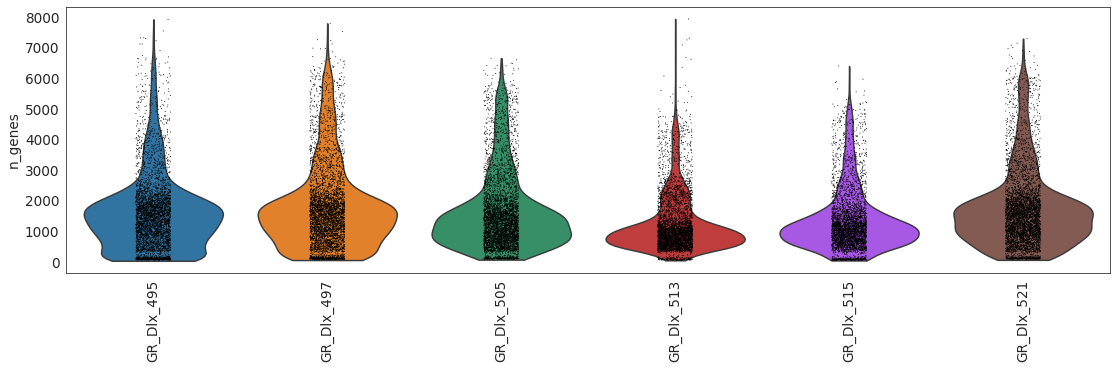

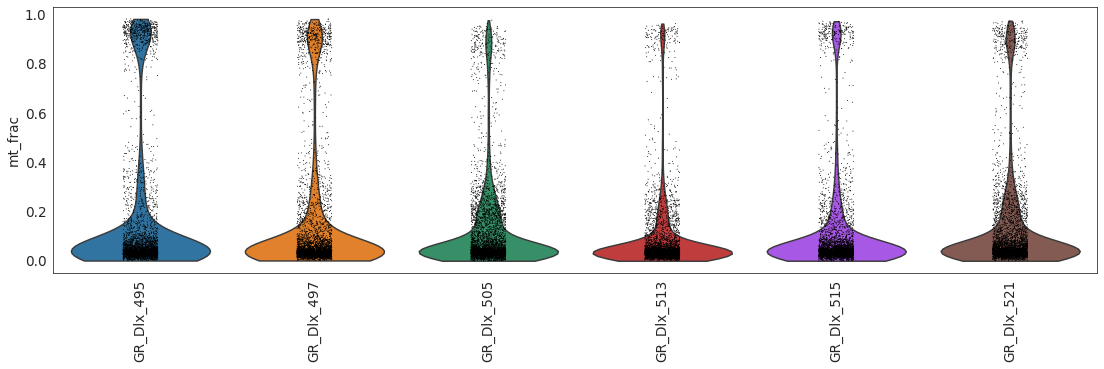

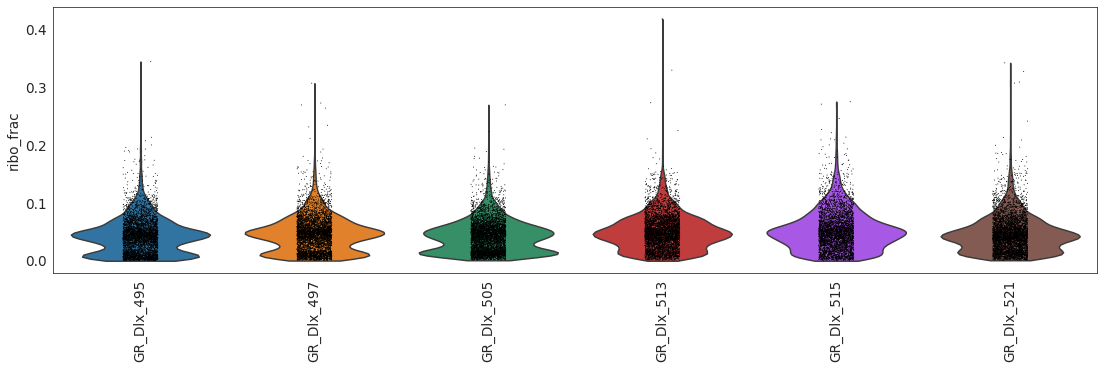

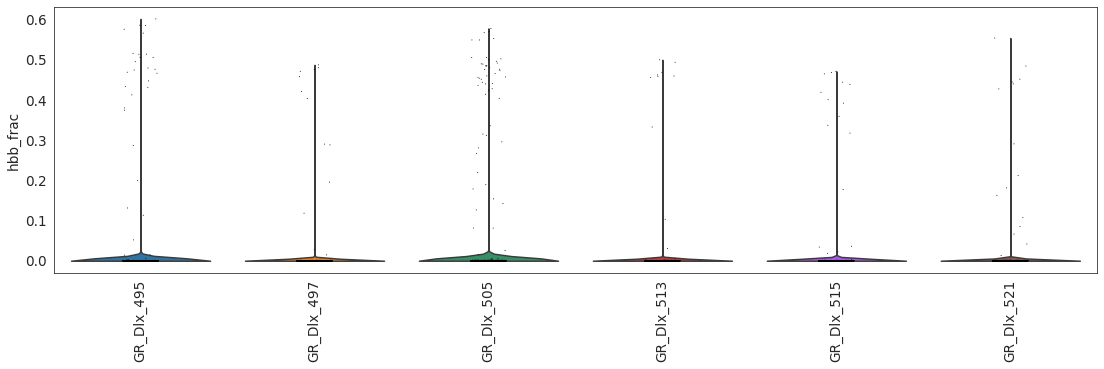

In [9]:
plt.rcParams['figure.figsize'] = (15, 5)
for data_plot in ['n_counts', 'log_counts', 'n_genes', 'mt_frac', 'ribo_frac', 'hbb_frac']:
    sc.pl.violin(
        adata, 
        data_plot, 
        groupby='sample', 
        size=1, 
        log=False,
        rotation=90
    )

## GR Dlx 495

In [10]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_495'].copy()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


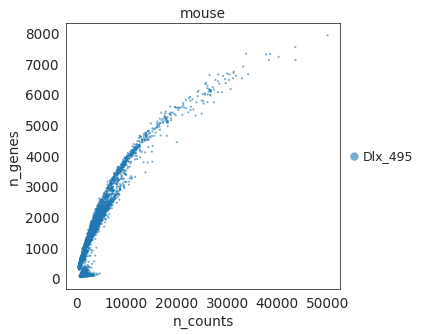

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


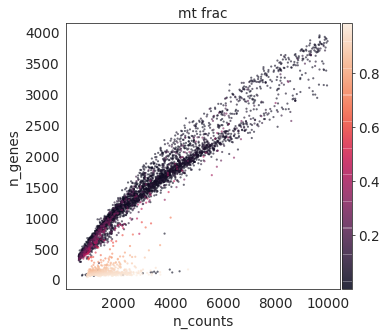

In [11]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


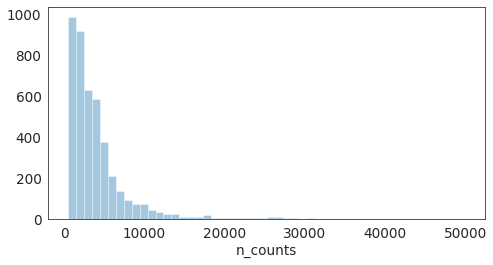

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


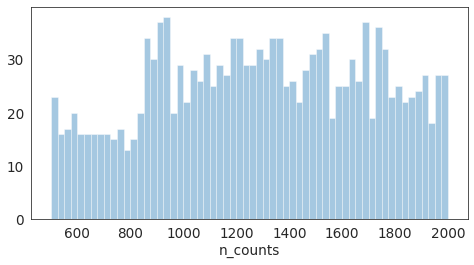

In [12]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<2000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


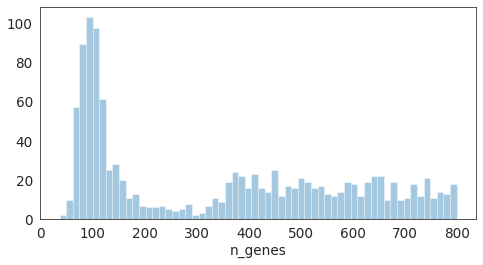

In [13]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<800], kde=False, bins=60)
plt.show()

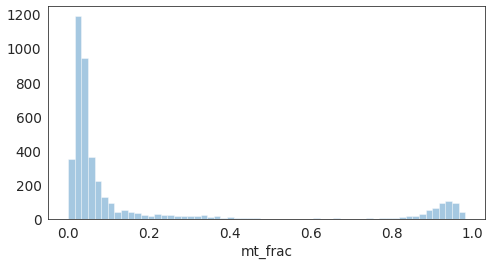

In [14]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


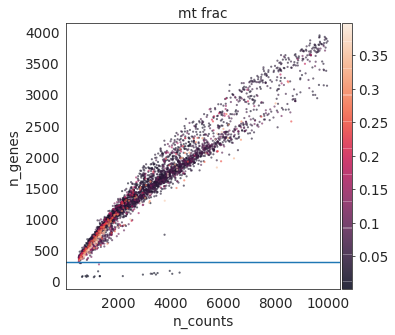

In [15]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(300)

In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 300)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1000), (adata_sample.obs['n_counts'] > 3000))]
print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4367
Number of cells after MT filter: 3745
Number of cells after gene filter: 3720
Number of cells after joint gene-counts filter: 3719


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-pack

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


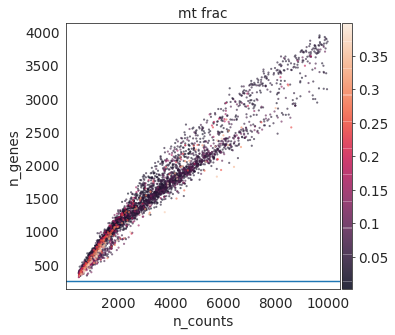

In [17]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(250)

In [18]:
adata_gr_dlx_495 = adata_sample.copy()

## GR Dlx 497

In [19]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_497'].copy()

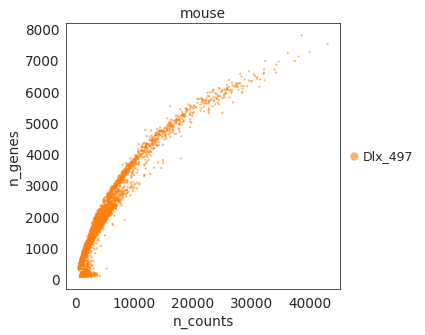

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


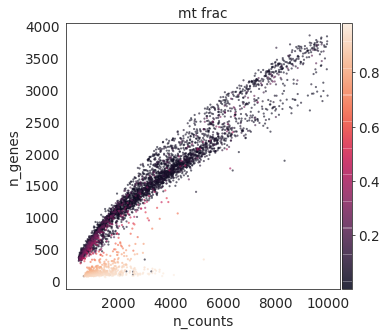

In [20]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


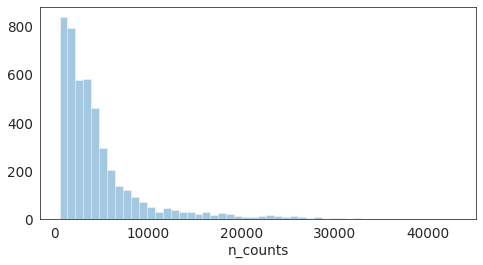

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


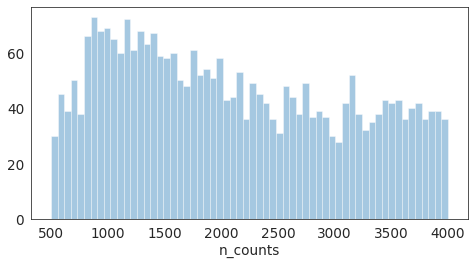

In [21]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


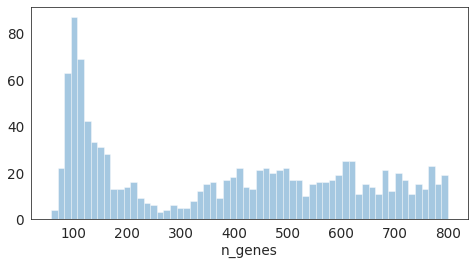

In [22]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<800], kde=False, bins=60)
plt.show()

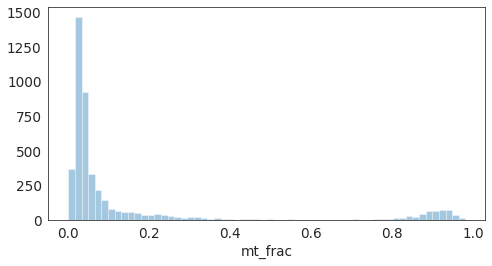

In [23]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


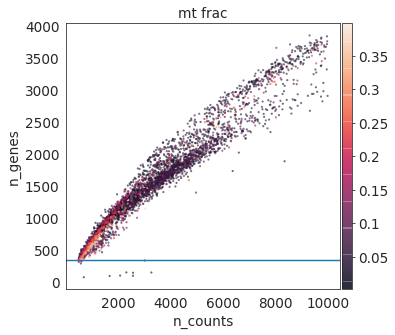

In [24]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [25]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 350)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

#adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1500), (adata_sample.obs['n_counts'] > 6000))]
#print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4672
Number of cells after MT filter: 4097
Number of cells after gene filter: 4069


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


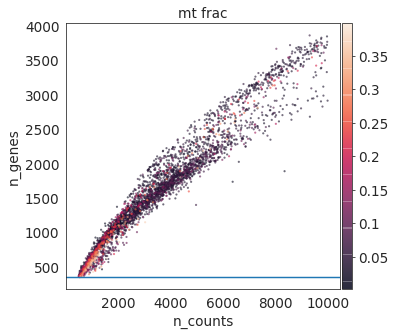

In [26]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [27]:
adata_gr_dlx_497 = adata_sample.copy()

## GR Dlx 405

In [28]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_505'].copy()

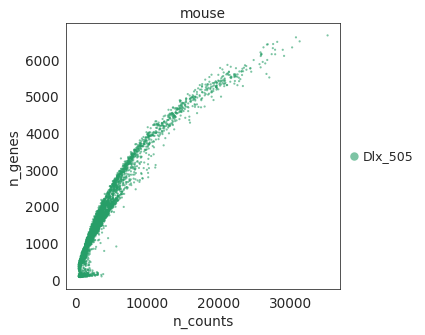

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


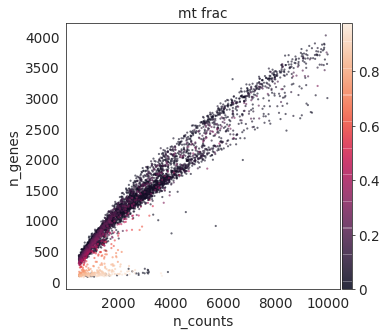

In [29]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


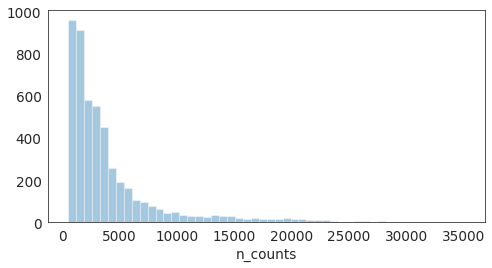

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


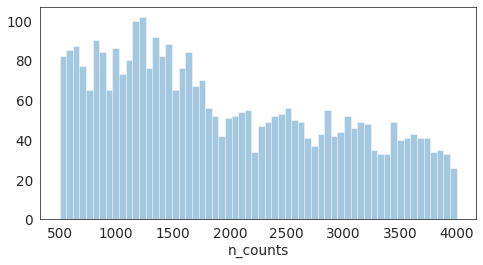

In [30]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


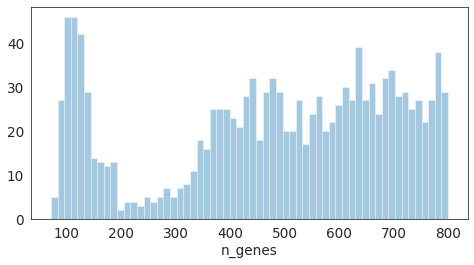

In [31]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<800], kde=False, bins=60)
plt.show()

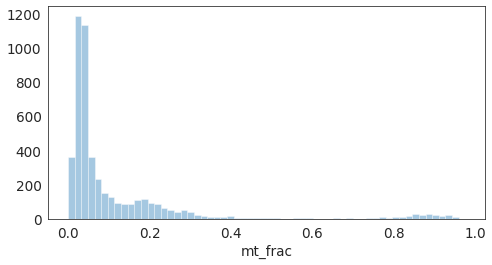

In [32]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


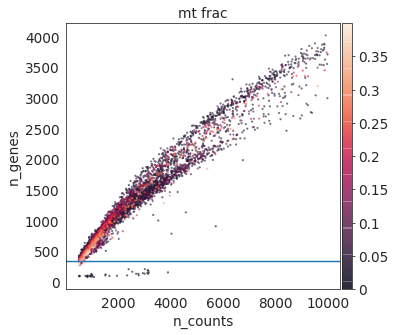

In [33]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [34]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 350)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1500), (adata_sample.obs['n_counts'] > 4000))]
print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4930
Number of cells after MT filter: 4600
Number of cells after gene filter: 4525
Number of cells after joint gene-counts filter: 4521


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-pack

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


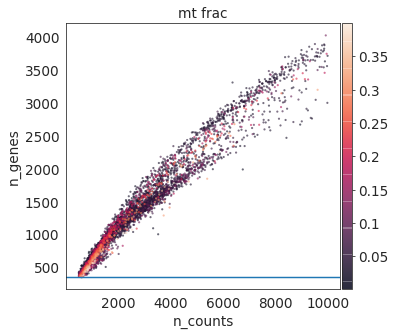

In [35]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [36]:
adata_gr_dlx_505 = adata_sample.copy()

## GR Dlx 513

In [37]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_513'].copy()

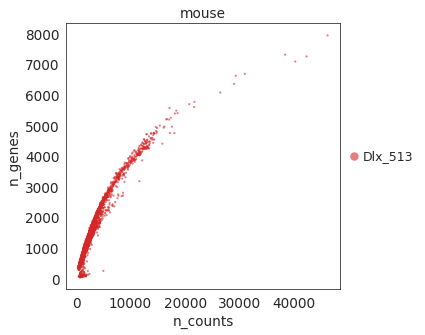

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


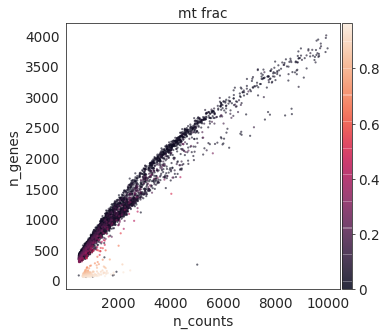

In [38]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


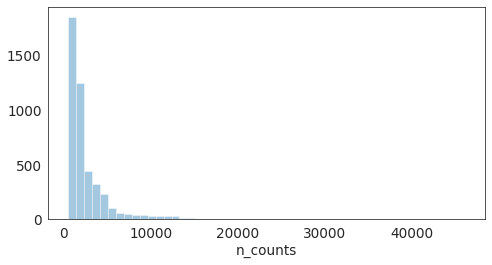

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


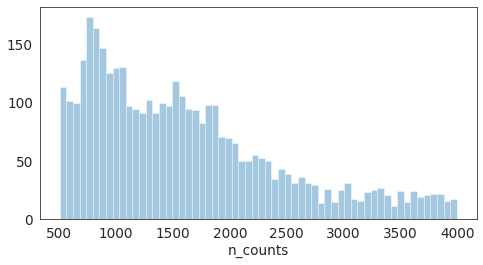

In [39]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


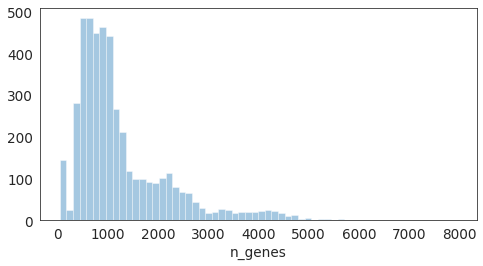

In [40]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<8000], kde=False, bins=60)
plt.show()

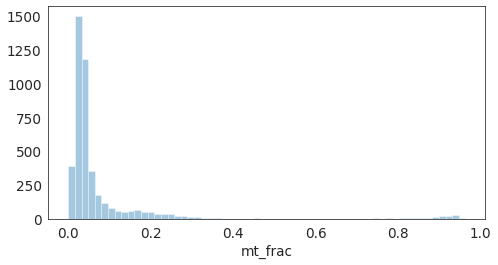

In [41]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


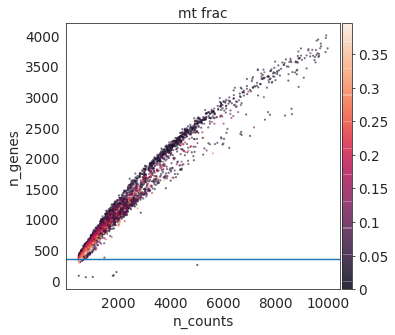

In [42]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [43]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 350)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

#adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1500), (adata_sample.obs['n_counts'] > 6000))]
#print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4555
Number of cells after MT filter: 4368
Number of cells after gene filter: 4319


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


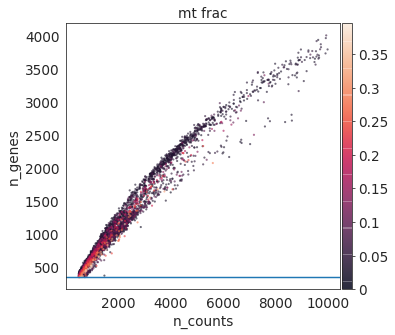

In [44]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(350)

In [45]:
adata_gr_dlx_513 = adata_sample.copy()

## GR Dlx 515

In [46]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_515'].copy()

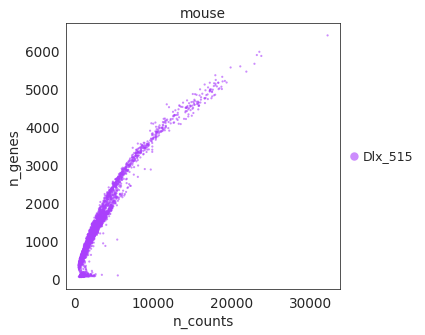

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


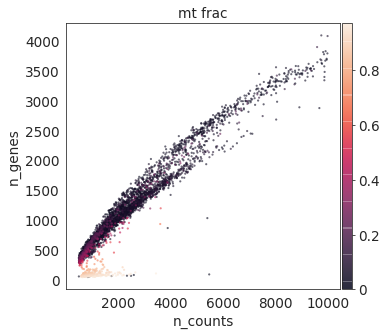

In [47]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


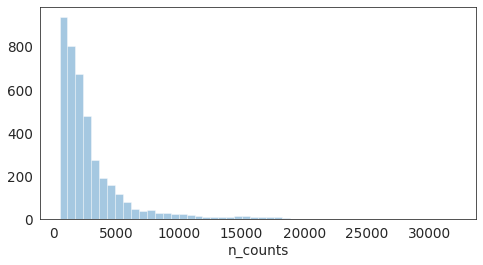

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


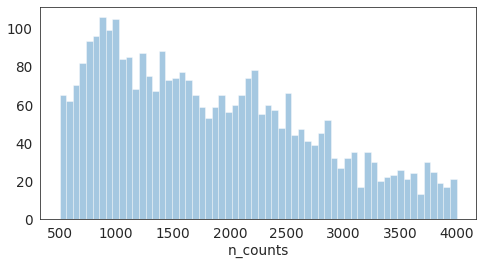

In [48]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


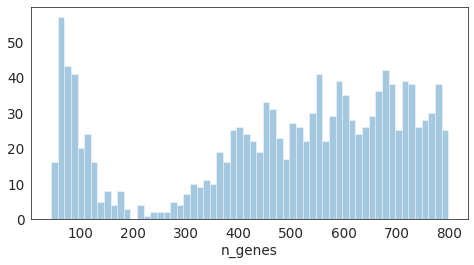

In [49]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<800], kde=False, bins=60)
plt.show()

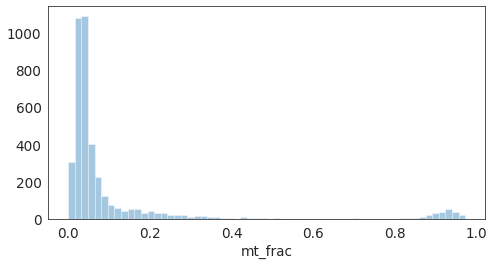

In [50]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


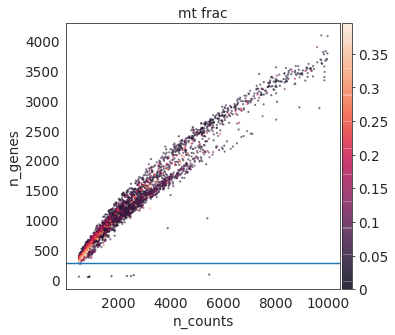

In [51]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(280)

In [52]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 280)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1200), (adata_sample.obs['n_counts'] > 3000))]
print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4110
Number of cells after MT filter: 3809
Number of cells after gene filter: 3798
Number of cells after joint gene-counts filter: 3795


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-pack

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


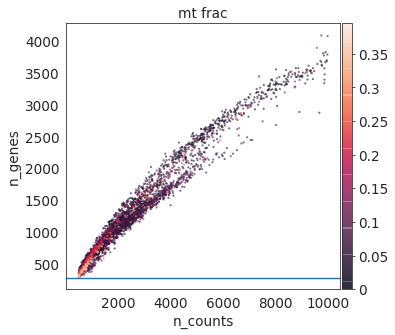

In [53]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(280)

In [54]:
adata_gr_dlx_515 = adata_sample.copy()

## GR Dlx 521

In [55]:
adata_sample = adata[adata.obs['sample']=='GR_Dlx_521'].copy()

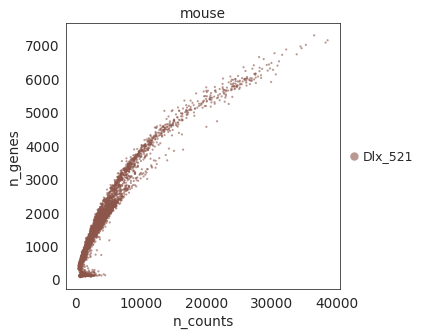

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


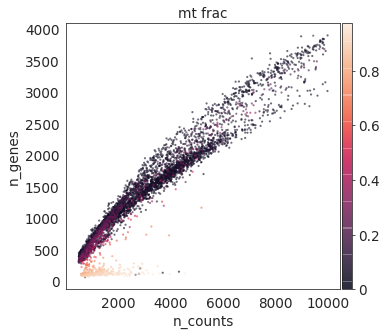

In [56]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_sample, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


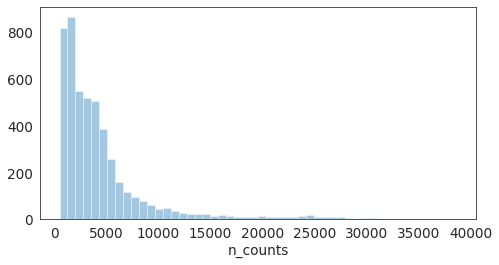

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


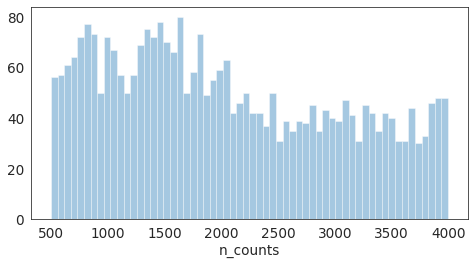

In [57]:
#Thresholding decision: counts
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_counts'], kde=False)
plt.show()

sns.distplot(adata_sample.obs['n_counts'][adata_sample.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


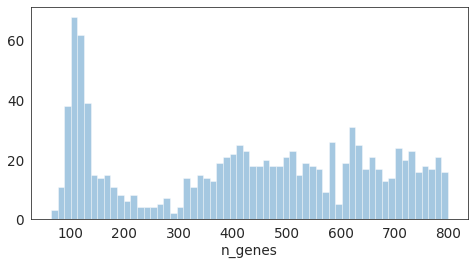

In [58]:
#Thresholding decision: n_genes
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['n_genes'][adata_sample.obs['n_genes']<800], kde=False, bins=60)
plt.show()

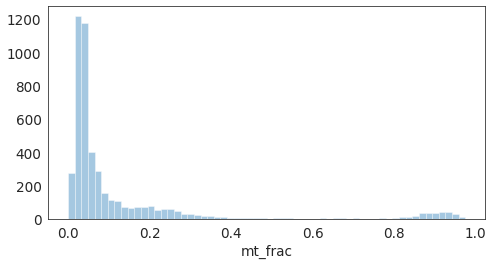

In [59]:
#Thresholding decision: mt_frac
plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(adata_sample.obs['mt_frac'], kde=False, bins=60)
plt.show()

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


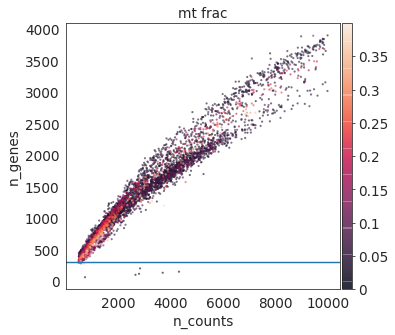

In [60]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[(adata_sample.obs['n_counts']<10000)&(adata_sample.obs['mt_frac'] < 0.4)], \
                                'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(300)

In [61]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata_tmp, min_counts = 1000)
#print('Number of cells after min count filter: {:d}'.format(adata_sample.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata_sample = adata_sample[adata_sample.obs['mt_frac'] < 0.4]
print('Number of cells after MT filter: {:d}'.format(adata_sample.n_obs))

adata_sample = adata_sample[(adata_sample.obs['n_genes'] > 300)]
print('Number of cells after gene filter: {:d}'.format(adata_sample.n_obs))

#adata_sample = adata_sample[~np.logical_and((adata_sample.obs['n_genes'] < 1000), (adata_sample.obs['n_counts'] > 3000))]
#print('Number of cells after joint gene-counts filter: {:d}'.format(adata_sample.n_obs))

Total number of cells: 4868
Number of cells after MT filter: 4483
Number of cells after gene filter: 4474


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


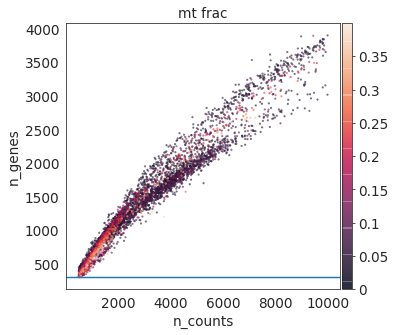

In [62]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.scatter(adata_sample[adata_sample.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6, show=False)
ax.axhline(300)

In [63]:
adata_gr_dlx_521 = adata_sample.copy()

# Put everything together

In [64]:
adata.obs['mouse'].unique()

['Dlx_495', 'Dlx_515', 'Dlx_505', 'Dlx_513', 'Dlx_521', 'Dlx_497']
Categories (6, object): ['Dlx_495', 'Dlx_515', 'Dlx_505', 'Dlx_513', 'Dlx_521', 'Dlx_497']

In [65]:
adata_qc = adata_gr_dlx_495.concatenate([adata_gr_dlx_515, adata_gr_dlx_505, adata_gr_dlx_513,
                                            adata_gr_dlx_521, adata_gr_dlx_497])

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'mouse' as categorical
... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'comb' as categorical


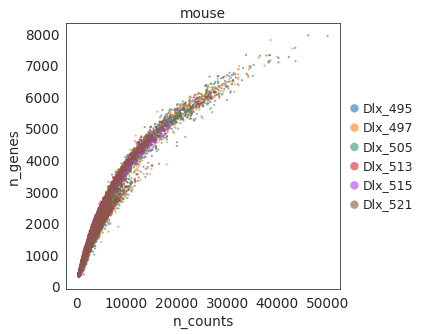

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


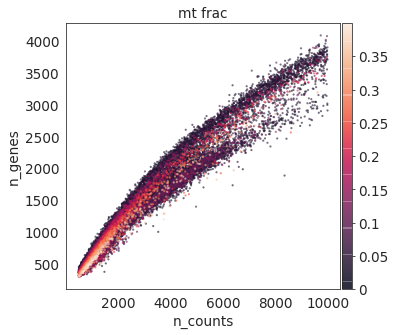

In [66]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata_qc, 'n_counts', 'n_genes', size=20, color='mouse', alpha=0.6)
sc.pl.scatter(adata_qc[adata_qc.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=20, alpha=0.6)

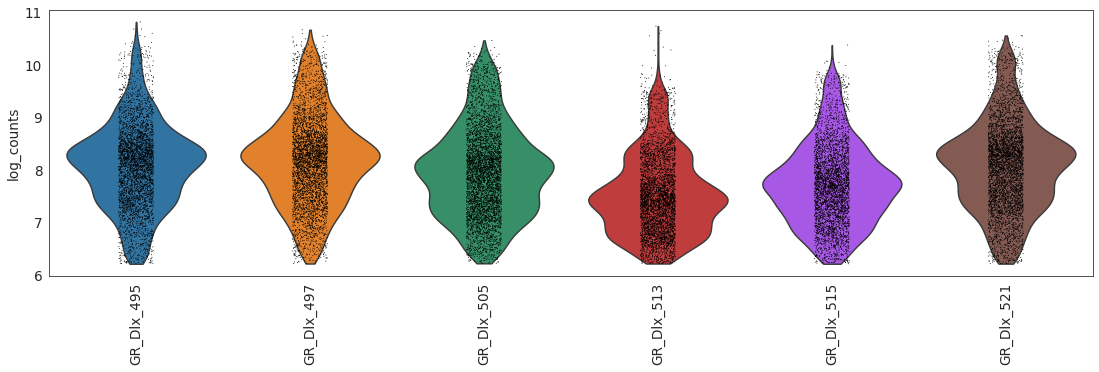

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


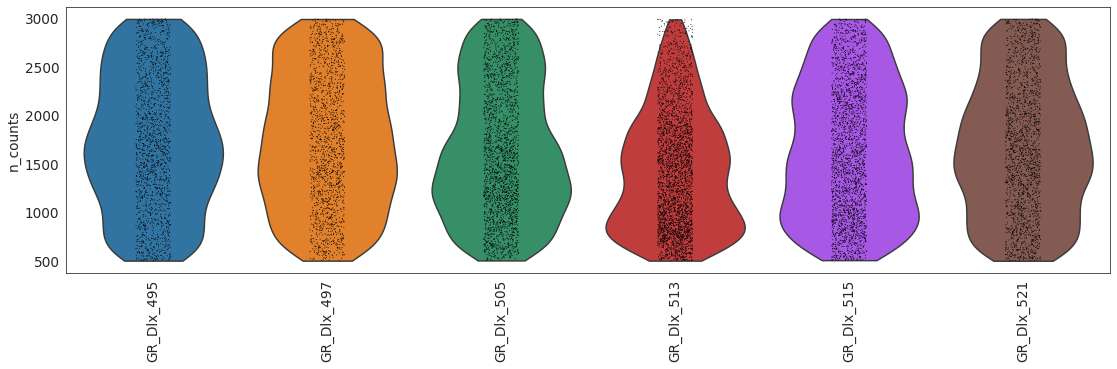

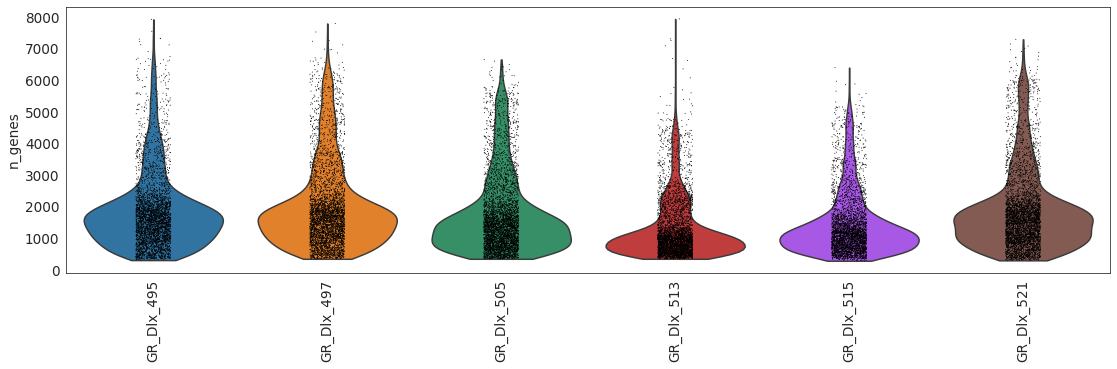

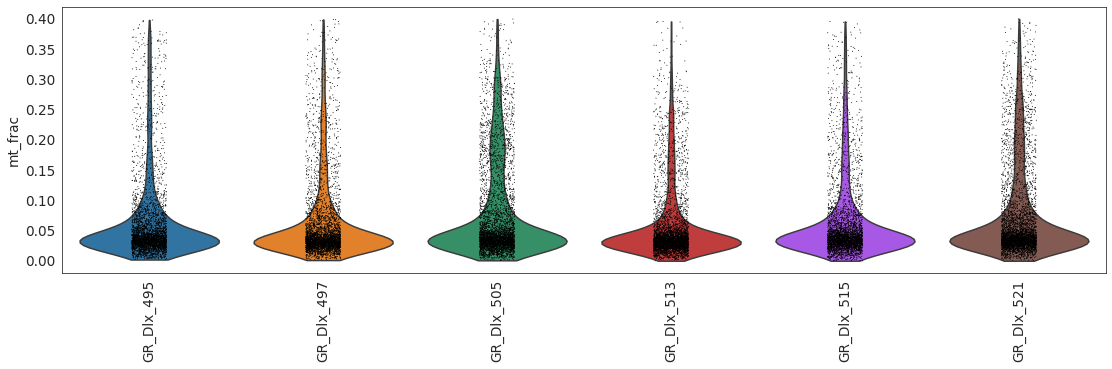

In [67]:
plt.rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_qc, ['log_counts'], groupby='sample', size=1, log=False,rotation=90)
sc.pl.violin(adata_qc[(adata_qc.obs['n_counts'] > 500) & (adata_qc.obs['n_counts'] < 3000)], ['n_counts'], groupby='sample', size=1, log=False,rotation=90)
sc.pl.violin(adata_qc, ['n_genes'], groupby='sample', size=1, log=False,rotation=90)
sc.pl.violin(adata_qc, ['mt_frac'], groupby='sample', size=1, log=False,rotation=90)

In [68]:
adata_qc.write('../../data/processed/QC/adata_grdlx_filtered.h5ad')